In [1]:
# Environment libraries
from tf_agents.environments import utils
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import wrappers
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
import numpy as np

# Simulation libraries
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment

from tf_agents.trajectories import trajectory
from tf_agents.environments import wrappers

#from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

import matplotlib.pyplot as plt

In [2]:
# Load the trained neural network
from tensorflow.keras.models import load_model
model = load_model('model.h5')
model_reward=load_model('model_reward.h5')

In [3]:
import pandas as pd
df=pd.read_csv("state_esti_main.csv")
df_1=df.iloc[:,0:4]
means_curr_state = df_1.mean().tolist()
stds_curr_state = df_1.std().tolist()

In [4]:
df_2=df["curr_reward"]
means_reward = df_2.mean()
stds_reward = df_2.std()


In [5]:
df_3=df["curr_CDP"]
means_CDP = df_3.mean()
stds_CDP = df_3.std()


In [13]:
from numpy import array
import random
class CustomerSimulatorEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=4, name='action')
        
        # 3D for the actual problem
        self._observation_spec = array_spec.ArraySpec(shape=(4,), dtype=np.float32, name='observation')
        #self.set_state=array_spec.ArraySpec(shape=(4,), dtype=np.float32, name='setstate')
        self._state = array_spec.ArraySpec(shape=(4,), dtype=np.float32, name='state')
        self._episode_ended = False
        
        #new variables
        self._step_count = 0
        self._current_state = array_spec.ArraySpec(shape=(1,4), dtype=np.float32, name='currentstate')
        self._next_state = array_spec.ArraySpec(shape=(1,4), dtype=np.float32, name='nextstate')
        self._step_reward = 0
        # action dictionary
        self._action_dict ={0:0,1:1,2:5,3:10,4:15}
        ##############################################################
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
        
    
#     def set_state(self,cust_state):
#         assert (len(cust_state)==4),'cust_state is wrong'
#         self._step_count = 0
#         self._episode_ended = False
#         self._current_state =cust_state
#         self._next_state = [0.0,0.0,0.0,0.0]
#         self._state =cust_state
#         return ts.restart(np.array(self._state, dtype=np.float32))
        
        
    def _reset(self):
        state_dct={1:[20.66666667,0.166666667,47.83333333,0.17],2:[30.71428571,0.428571429,73.14285714,0.29],3:[41.14285714,0.142857143,91.42857143,0.14],
                  4:[869,0.142857143,26.57142857,0.14],5:[1263.571429,0.142857143,31.85714286,0.14]}
        self._step_count = 0
        self._episode_ended = False
        self._current_state =GLOBAL_STATE
        self._next_state = [0.0,0.0,0.0,0.0]
        self._state =self._current_state
        return ts.restart(np.array(self._state, dtype=np.float32))
    def scaled(self,state):
        state=[state[i] - means_curr_state[i] for i in range(len(means_curr_state))]
        res=[]
        for i in range(len(means_curr_state)):
            res.append(state[i]/stds_curr_state[i])
        return res
    def unscaled(self,state):
        state=[(state[i] *stds_curr_state[i]) + means_curr_state[i] for i in range(len(means_curr_state))]
        return state
        

    def _step(self, action):
        
        self._step_count += 1
        
        if (self._step_count > 6):
            self._epsiode_ended = True
       
        if self._episode_ended:
            return self.reset()
        
        if (action > 4):
            raise ValueError("Action value out of bounds")
        
        move = self._action_dict[int(action)]
        move=move-means_CDP
        move=move/stds_CDP
        self._current_state=self.scaled(self._current_state)
        self._current_state.append(move)
        self._current_state=np.array(self._current_state)
        self._current_state=self._current_state.reshape((1, 5))
        self._next_state =model.predict(self._current_state)
        rev_1 =model_reward.predict(self._next_state)
        rev=rev_1[0][0]
        rev=(rev*stds_reward)+means_reward
        print(rev)
        self._current_state = self._next_state
        self._current_state=self._current_state.ravel().tolist()
        self._current_state=self.unscaled(self._current_state)
        self._state = self._current_state
        
        if rev < -0.01:
            return ts.transition(np.array(self._state, dtype=np.float32), reward=rev, discount=1)
        else:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=rev)

In [14]:
GLOBAL_STATE=[18.71428571,0.285714286,39.71428571,0.14]
pp = CustomerSimulatorEnv()
utils.validate_py_environment(pp, episodes=5)
print ('Customer Simulator Environment Validated')

1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
210.74959206299172
1/1 [==============================] - 0s 7ms/step
-9.518892075072579
1/1 [==============================] - 0s 8ms/step
367.0138963067999
1/1 [==============================] - 0s 7ms/step
-100.45770962444334
1/1 [==============================] - 0s 7ms/step
-69.728687005269
1/1 [==============================] - 0s 7ms/step
-142.12827238933775
1/1 [==============================] - 0s 7ms/step
-823.0725806936653
1/1 [==============================] - 0s 7ms/step
-1322.0995885307548
1/1 [==============================] - 0s 7ms/step
-2485.5267515829755
1/1 [==============================] - 0s 7ms/step
-3491.4999423787926
1/1 [==============================] - 0s 7ms/step
-3695.5052748290977
1/1 [==============================] - 0s 7ms/step
-4558.619339542319
1/1 [==============================] - 0s 7ms/step
-5150.691715202736
1/1 [==============

In [15]:
pp._reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([18.714285 ,  0.2857143, 39.714287 ,  0.14     ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [ ]:
#tf_pp=tf_py_environment.TFPyEnvironment(pp)


In [ ]:
#print(tf_pp)

In [ ]:
# train_py_env =CustomerSimulatorEnv()
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# print (train_env.reset())

In [ ]:
#train_env._reset([23,3,4,4])

In [16]:
pp.step(0)

1/1 [==============================] - 0s 10ms/step
36.61333455722911


TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([1.9763216e+02, 7.2522692e-02, 7.8329910e+01, 1.4076467e-01],
      dtype=float32),
 'reward': array(36.613335, dtype=float32),
 'step_type': array(2, dtype=int32)})

In [17]:
if __name__ == '__main__':
    env = CustomerSimulatorEnv()
    #utils.validate_py_environment(env, episodes=5)
    tl_env = wrappers.TimeLimit(env, duration=50)

    print ('Reset step') 
    time_step = tl_env.reset()
    rewards = time_step.reward
    print ('Rewards', rewards)
    print ('In Loop')
    print ('~~~~~~~~~~')
    
    #actlist = []
    #rewlist = []
    for i in range(100):
        action = np.random.choice([0,1,2,3,4])
        print ('action is', action)
        time_step = tl_env.step(action)
        print(action, time_step.observation)
        rewards += time_step.reward
        #actlist.append(action)
        #rewlist.append(float(time_step.reward))
        print ('%%%%%')

    print(rewards)

Reset step
Rewards 0.0
In Loop
~~~~~~~~~~
action is 0
1/1 [==============================] - 0s 10ms/step
36.61333455722911
0 [1.9763216e+02 7.2522692e-02 7.8329910e+01 1.4076467e-01]
%%%%%
action is 3
3 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 2
1/1 [==============================] - 0s 7ms/step
53.756125315615755
2 [4.2873331e+02 1.3487796e-01 2.1930078e+02 8.4656751e-01]
%%%%%
action is 0
0 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 4
1/1 [==============================] - 0s 7ms/step
71.1122541391372
4 [4.6679309e+02 1.5421352e-01 5.3923865e+02 2.2510006e+00]
%%%%%
action is 1
1 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 0
1/1 [==============================] - 0s 7ms/step
36.61333455722911
0 [1.9763216e+02 7.2522692e-02 7.8329910e+01 1.4076467e-01]
%%%%%
action is 2
2 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 3
1/1 [==============================] - 0s 7ms/step
65.02944690708588
3 [4.6987283e+02 1.62240

1/1 [==============================] - 0s 8ms/step
65.02944690708588
3 [4.6987283e+02 1.6224022e-01 3.7925058e+02 1.5483046e+00]
%%%%%
action is 4
4 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 3
1/1 [==============================] - 0s 8ms/step
65.02944690708588
3 [4.6987283e+02 1.6224022e-01 3.7925058e+02 1.5483046e+00]
%%%%%
action is 2
2 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 2
1/1 [==============================] - 0s 7ms/step
53.756125315615755
2 [4.2873331e+02 1.3487796e-01 2.1930078e+02 8.4656751e-01]
%%%%%
action is 0
0 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 0
1/1 [==============================] - 0s 7ms/step
36.61333455722911
0 [1.9763216e+02 7.2522692e-02 7.8329910e+01 1.4076467e-01]
%%%%%
action is 1
1 [18.714285   0.2857143 39.714287   0.14     ]
%%%%%
action is 4
1/1 [==============================] - 0s 7ms/step
71.1122541391372
4 [4.6679309e+02 1.5421352e-01 5.3923865e+02 2.2510006e+00]
%%%%%
action is 3
3

In [18]:
env.reset()


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([18.714285 ,  0.2857143, 39.714287 ,  0.14     ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [19]:
## Writing a function to declare the environment

def declareenv():   
    train_py_env = wrappers.TimeLimit(CustomerSimulatorEnv(), duration=100)
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)
    print (train_env.reset())
     
    return (train_env)

In [20]:
train_env = declareenv()
eval_env = declareenv()

# Evaluate a few things
print (train_env.action_spec())
print (train_env.observation_spec())
print (train_env.time_step_spec())
print (train_env.reset())

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))
TensorSpec(shape=(4,), dtype=tf.float32, name='observation')
TimeStep(


In [ ]:
# GLOBAL_STATE=[12,24,21,34]
# test_env=declareenv()

In [ ]:
#test_env.reset()

In [21]:
#set up for the simulations
# Compute average return 
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [22]:
# Set Parameters
num_iterations = 10000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 10000 # @param

fc_layer_params = (10,5)

batch_size = 128  # @param
learning_rate = 1e-4  # @param
log_interval = 200  # @param

num_eval_episodes =2 # @param
eval_interval = 1000  # @param

In [23]:
# Set up the Q network
q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

# Set up the optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer = tf.optimizers.SGD (learning_rate=0.001, name='SGD')

train_step_counter = tf.compat.v2.Variable(0)

# Set up the agent
tf_agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn = common.element_wise_squared_loss,  #dqn_agent.element_wise_squared_loss,
        train_step_counter=train_step_counter)

tf_agent.initialize()

In [24]:
# Set up the policy
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_capacity)

print("Batch Size: {}".format(train_env.batch_size))

# Create reply observer
replay_observer = [replay_buffer.add_batch]

# Train metrics
train_metrics = [
            tf_metrics.NumberOfEpisodes(),
            tf_metrics.EnvironmentSteps(),
            tf_metrics.AverageReturnMetric(),
            tf_metrics.AverageEpisodeLengthMetric(),
]

Batch Size: 1


In [25]:
# Collect trajectories
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)
    
# Set up the datastep and driver
dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [26]:
# Some prints
episode_len = []
step_len = []
loss_fun = []

In [27]:
tf_agent.train = common.function(tf_agent.train)
tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [28]:
def onerun(env, episode_len, step_len, loss_fun):
    
    driver = dynamic_step_driver.DynamicStepDriver(
            train_env,
            collect_policy,
            observers=replay_observer + train_metrics,
    num_steps=1)

    print(compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes))

    final_time_step, policy_state = driver.run()

    for i in range(100):
        final_time_step, _ = driver.run(final_time_step, policy_state)
    
    for i in range(num_iterations):
        final_time_step, _ = driver.run(final_time_step, policy_state)
        #for _ in range(1):
        #    collect_step(train_env, tf_agent.collect_policy)

        experience, _ = next(iterator)
        train_loss = tf_agent.train(experience=experience)
        step = tf_agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss.loss))
            episode_len.append(train_metrics[3].result().numpy())
            step_len.append(step)
            loss_fun.append(train_loss.loss)
            
            print('Average episode length: {}'.format(train_metrics[3].result().numpy()))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))


    return (episode_len, step_len, loss_fun)

In [29]:
train_env = declareenv()
print (train_env.reset())
print ('###############################')
episode_len, step_len, loss_fun = onerun(train_env, episode_len, step_len, loss_fun)

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
###############################
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
71.11225
1/1 [==========

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 10ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 10ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
53.756125315615755
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 11ms/step
71.1122541391372
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 1400: loss = 1012.0244140625
Average episode length: 1.0
1/1 [==============================] - 0s 9ms/step
7

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 1800: loss = 695.3189697265625
Average episode length: 1.0
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/ste

1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [========================

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [=========================

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 15ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7m

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 12ms/step
71.1122541391372
1/1 [==============================] - 0s 10ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7m

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 4400: loss = 0.02527039125561714
Average episode length: 1.0
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7m

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 4800: loss = 0.010644428431987762
Average episode length: 1.0
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
38.89171685587621
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 14ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 17ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
65.02944690708588
1/1 [==============================] - 0s 8ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 10ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 7400: loss = 7.620656106155366e-09
Average episode length: 1.0
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
step = 7800: loss = 3.571358320186846e-09
Average episode length: 1.0
1/1 [==============================] - 0s 11ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 18ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/s

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 16ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 18ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 12ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
38.89171685587621
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 14ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 9ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
53.756125315615755
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
36.61333455722911
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/s

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 8ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
71.1122541391372
1/1 [==============================] - 0s 7ms/step
65.02944690708588
1/1 [==============================] - 0s 8ms/

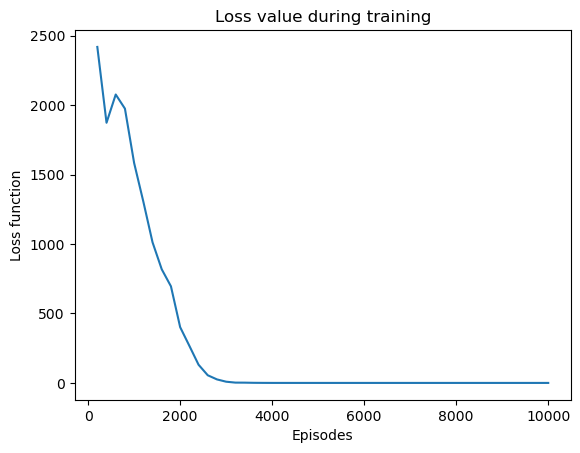

In [30]:
plt.plot(step_len, loss_fun)
plt.xlabel('Episodes')
plt.ylabel('Loss function')
plt.title('Loss value during training')
plt.show()

In [31]:
# reset new environment
newenv = declareenv()
time_step = newenv.reset()
#time_step = newenv.set_state(startpos[0], startpos[1])
print (time_step)

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.714285 ,  0.2857143, 39.714287 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})


In [32]:
nsteps = 0
    
while not time_step.is_last():
    action = tf_agent.policy.action(time_step)
    print ('action take is', action.action)
    time_step = newenv.step(action.action)
    nsteps +=1
    print ('new time step is', time_step)

print ('time steps to reach destination from starpos is', nsteps)

action take is tf.Tensor([4], shape=(1,), dtype=int32)
1/1 [==============================] - 0s 9ms/step
71.1122541391372
new time step is TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[4.6679309e+02, 1.5421352e-01, 5.3923865e+02, 2.2510006e+00]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([71.11225], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>})
time steps to reach destination from starpos is 1


In [33]:
import pandas as pd
import numpy as np
df_new=pd.read_csv("myfiltereddataset.csv")
X=df_new[["rolling_number_of_product","rolling_number_of_coupon_redem","rolling_tran_value"
          ,"Coupan_redemtion_percentage_in_last_transaction"]]
y=df_new[["curr_reward"]]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
#X_val.to_csv('X_val.csv', index=False)
#y_val.to_csv('y_val.csv',index=False)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
#X_val=pd.read_csv('X_val.csv')
#y_val=pd.read_csv('y_val.csv')
hist_state=X_test.to_numpy().tolist()


In [34]:
res=[]
for k in range(len(hist_state)):
    GLOBAL_STATE=hist_state[k]
    newenv = declareenv()
    time_step = newenv.reset()
    action = tf_agent.policy.action(time_step)
    print ('action take is', action.action)
    action_tensor = action.action
    action_list = action_tensor.numpy().tolist()
    res.append(action_list)

    
    
    
    
               

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.4285715, 0.       , 2.2857144, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[768.8571  ,   0.      ,  12.714286,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.571428,  0.      , 31.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.714285,  0.      , 36.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.142858,  0.      , 19.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[26.     ,  0.     , 89.42857,  0.     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.571428 ,  0.2857143, 14.       ,  0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.75, 0.  , 6.25, 0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.714286 ,  0.2857143, 44.714287 ,  0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[7.      , 0.      , 7.571429, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 9.428572  ,  0.14285715, 17.857143  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[29.,  0., 61.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 '

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.4, 0. , 5.2, 0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.571429, 0.      , 9.142858, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, n

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.571429,  0.      , 15.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.6666665, 0.       , 6.       , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1.2, 0. , 1. , 0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.142858,  0.      , 23.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.714286,  0.      , 23.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[24.714285  ,  0.14285715, 82.28571   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.857143, 0.      , 4.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.857143,  0.      , 17.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.714286,  0.      , 34.714287,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.857143, 0.      , 6.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.571428,  0.      , 16.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.714286,  0.      , 31.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.571429, 0.      , 7.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.571428,  0.      , 17.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.285714,  0.      , 13.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.142858,  0.      , 24.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.5714285, 0.       , 4.857143 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.285714,  0.      , 11.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.285714,  0.      , 24.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.333334,  0.      , 33.666668,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.857143,  0.      , 18.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.      , 0.      , 8.666667, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.428572,  0.      , 24.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714,  0.      , 23.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.333333,  0.      , 23.666666,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.571429, 0.      , 7.857143, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.5, 0. , 6.5, 0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.428572,  0.      , 30.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.714286, 0.      , 8.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[13.857142  ,  0.14285715, 26.142857  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.],

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.142857,  0.      , 65.57143 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.      ,  0.      , 15.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.5     ,  0.      , 22.166666,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.142857,  0.      , 16.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.142857,  0.      , 14.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[10.142858  ,  0.14285715, 24.285715  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.,  0., 22.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.5,  0. , 33.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1,

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[11.571428  ,  0.71428573, 26.571428  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.142858,  0.      , 25.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.571428,  0.      , 14.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 7.142857  ,  0.14285715, 21.571428  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[19.75,  0.  , 36.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.714286,  0.      , 32.714287,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[13.        ,  0.14285715, 21.857143  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.857142,  0.      , 20.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.428571, 0.      , 9.857142, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.714286, 0.      , 8.142858, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[30.25,  0.  , 43.5 ,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.142857,  0.      , 16.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 6.142857  ,  0.14285715, 13.142858  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[19.5,  0. , 51.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 4.571429,  0.      , 13.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[34.6,  0. , 83.6,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.4285715, 0.       , 7.142857 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 3.7142856,  0.       , 13.142858 ,  0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[674.1429  ,   0.      ,  43.142857,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.666667,  0.      , 21.666666,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.571429, 0.      , 9.571428, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[801.5714 ,   0.     ,  72.57143,   0.     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.857143,  0.      , 35.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.857142,  0.      , 11.714286,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.7142856, 0.       , 4.428571 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.7142856, 0.       , 5.285714 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.857142,  0.      , 20.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.      ,  0.      , 19.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714,  0.      , 17.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.      ,  0.      , 19.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.      , 0.      , 5.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[23.428572,  0.      , 40.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[33.142857,  0.      , 63.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[27.        ,  0.33333334, 34.166668  ,  0.17      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.857142,  0.      , 21.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.857142,  0.      , 26.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[31.,  0., 41.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.285714, 0.      , 4.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, n

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.666667,  0.      , 13.333333,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[23.571428,  0.      , 58.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[525.,   0.,  42.,   0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.428571,  0.      , 11.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[31.714285,  0.      , 85.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5., 0., 8., 0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, n

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.428572,  0.      , 18.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.571429,  0.      , 21.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[967.8571  ,   0.      ,  22.428572,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.142858,  0.      , 28.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.285715,  0.      , 42.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.5,  0. , 14.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.142857,  0.      , 31.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.4285715, 0.       , 7.571429 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.285714,  0.      , 18.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.428572,  0.      , 50.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[29.571428,  0.      , 78.14286 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.285714, 0.      , 9.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.4285715, 0.       , 5.857143 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.285714,  0.      , 17.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.142857, 0.      , 7.571429, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.571429, 0.      , 8.857142, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20. ,  0. , 36.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[844.8571  ,   0.      ,  35.857143,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[7.714286, 0.      , 7.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.285714,  0.      , 13.285714,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.142858,  0.      , 13.714286,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.5 ,  0.  , 39.25,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.      ,  0.      , 21.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.285715,  0.      , 30.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.285714,  0.      , 16.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[31.857143,  0.      , 50.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.714286,  0.      , 11.714286,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.142857 ,  0.2857143, 44.714287 ,  0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.428571, 0.      , 6.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[14.        ,  0.14285715, 30.        ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[41.57143,  0.     , 96.57143,  0.     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20.714285 ,  0.2857143, 28.857143 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.571429,  0.      , 13.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[14.142858  ,  0.14285715, 33.857143  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[11.428572  ,  0.14285715, 20.571428  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[591.5714,   0.    ,  22.    ,   0.    ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.428572,  0.      , 40.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[23.714285 ,  0.5714286, 42.714287 ,  0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714 ,  0.2857143, 20.285715 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.      ,  0.      , 13.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[30. ,  0. , 48.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[22.285715,  0.      , 57.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.714286, 0.      , 6.571429, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[38.     ,  0.     , 78.14286,  0.     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.571429,  0.      , 14.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.142858,  0.      , 18.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[748.7143  ,   0.      ,  47.285713,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.857142,  0.      , 20.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[10.571428  ,  0.14285715, 21.571428  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.714286,  0.      , 16.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[19.,  0., 42.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7. ,  0. , 10.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.],

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.857142,  0.      , 18.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.714286, 0.      , 9.857142, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.571428,  0.      , 22.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.428571, 0.      , 7.142857, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.      ,  0.      , 17.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[22.428572,  0.      , 45.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.      , 0.      , 9.571428, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.714286,  0.      , 30.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.428571, 0.      , 8.142858, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.666666,  0.      , 49.333332,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[626.5714  ,   0.      ,   8.428572,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.714286,  0.      , 18.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.      ,  0.      , 16.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.428571,  0.      , 20.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[31.571428  ,  0.14285715, 48.57143   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[974.4286  ,   0.      ,  23.428572,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'disc

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.      ,  0.      , 24.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.142858,  0.      , 12.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[25.428572  ,  0.14285715, 55.42857   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.714285,  0.      , 43.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.428571,  0.      , 14.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.428572,  0.      , 19.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.      ,  0.      , 26.333334,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[563.8571  ,   0.      ,  11.285714,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20.142857 ,  0.2857143, 26.857143 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.5 ,  0.  , 31.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'obs

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.428572,  0.      , 37.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.285714,  0.      , 13.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.714286, 0.      , 9.428572, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1.4285715, 0.       , 0.5714286, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.142858,  0.      , 18.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.571428,  0.      , 38.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714,  0.      , 25.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.285714,  0.      , 24.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.428572,  0.      , 20.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[18.714285  ,  0.14285715, 43.42857   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.571428,  0.      , 39.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[7.8157141e+02, 2.8571430e-01, 1.6428572e+01, 1.4000000e-01]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.571428,  0.      , 27.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.428572,  0.      , 27.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.4285715, 0.       , 3.4285715, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.714285,  0.      , 34.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714,  0.      , 16.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[24.666666,  0.      , 32.666668,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.571429,  0.      , 18.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.428572,  0.      , 24.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.      ,  0.      , 42.285713,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.,  0., 16.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 3.5,  0. , 12. ,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 4.428571,  0.      , 11.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.428571,  0.      , 14.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[37.,  0., 50.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[46.142857,  0.      , 80.71429 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.6,  0. , 21.4,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.857142,  0.      , 30.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.142857,  0.      , 50.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[823.2857  ,   0.      ,  27.571428,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[28.8,  0. , 64.8,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[284.42856 ,   0.      ,  10.285714,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.571428,  0.      , 18.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.142857,  0.      , 41.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.285714, 0.      , 8.857142, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[21.428572,  0.      , 27.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.142858 ,  0.5714286, 23.       ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[24.714285,  0.      , 38.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[33.57143   ,  0.42857143, 98.71429   ,  0.29      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.,  0., 30.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.,  0., 12.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dty

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3., 0., 5., 0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.714286, 0.      , 9.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tenso

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.285714,  0.      , 17.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[31.285715,  0.      , 46.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.857143,  0.      , 20.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[528.5714,   0.    ,  42.    ,   0.    ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.      ,  0.      , 24.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[29.571428,  0.      , 52.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[22.428572,  0.      , 53.714287,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.       , 0.       , 7.3333335, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[24.       ,  0.2857143, 61.285713 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.714286,  0.      , 15.285714,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.2857144, 0.       , 3.142857 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.857142,  0.      , 30.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.714286,  0.      , 19.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.,  0., 41.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[26.142857,  0.      , 72.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.75,  0.  , 28.5 ,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.4285715, 0.       , 4.857143 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.571428,  0.      , 26.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[4.4671429e+02, 4.2857143e-01, 2.4285715e+01, 1.4000000e-01]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20.75,  0.  , 22.25,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.T

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11. ,  0. , 44.6,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[26.428572  ,  0.14285715, 68.28571   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[5.      , 0.      , 7.857143, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.571428,  0.      , 19.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.      , 0.      , 7.714286, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 4.571429,  0.      , 18.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.428571,  0.      , 14.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.428572,  0.      , 23.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[3.4371429e+02, 1.4285715e-01, 2.7285715e+01, 1.4000000e-01]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.5714285, 0.       , 6.857143 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[16.428572  ,  0.14285715, 31.714285  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 4.714286,  0.      , 17.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.428572,  0.      , 19.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.714286,  0.      , 15.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.666667,  0.      , 35.666668,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.142858,  0.      , 19.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.285714,  0.      , 14.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[23.571428,  0.      , 68.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.142858,  0.      , 33.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 4.8,  0. , 14. ,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.      , 0.      , 5.285714, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[6.      , 0.      , 9.142858, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.857143, 0.      , 6.428571, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[21.142857  ,  0.14285715, 25.571428  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20.428572,  0.      , 46.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.6,  0. , 65.2,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.3333335,  0.       , 19.       ,  0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[19.428572,  0.      , 31.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.,  0., 17.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.571429,  0.      , 14.285714,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.142858,  0.      , 17.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.857143,  0.      , 36.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.428571 , 0.5714286, 5.714286 , 0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[39.25,  0.  , 64.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.285714,  0.      , 24.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.428571,  0.      , 17.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.285714,  0.      , 34.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.571429,  0.      , 17.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3., 0., 4., 0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.857142,  0.      , 24.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.T

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.571428,  0.      , 37.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.571428,  0.      , 17.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.714286,  0.      , 60.57143 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.857143,  0.      , 11.714286,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.714286,  0.      , 26.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.714286,  0.      , 18.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2., 0., 8., 0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.571429, 0.      , 9.428572, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[599.      ,   0.      ,  23.714285,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[37.75,  0.  , 63.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[38.57143,  0.     , 95.71429,  0.     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.      ,  0.      , 20.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.3333333, 0.       , 9.       , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[22.571428 ,  0.2857143, 28.857143 ,  0.29     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 5.428571,  0.      , 11.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.6, 0. , 4.4, 0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.857142 ,  0.2857143, 25.142857 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[19.428572,  0.      , 36.57143 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.2,  0. , 15.6,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[20.142857,  0.      , 33.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.      ,  0.      , 15.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[26.428572,  0.      , 57.714287,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.5714285, 0.       , 8.       , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.,  0., 54.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[817.7143  ,   0.      ,  31.571428,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.285714,  0.      , 21.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.428572,  0.      , 26.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[846.7143,   0.    ,  49.    ,   0.    ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.285714,  0.      , 20.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.      ,  0.      , 27.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.,  0., 17.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.142857,  0.      , 25.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 8.428572  ,  0.14285715, 13.        ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[16.571428  ,  0.14285715, 36.42857   ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeS

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[11.285714  ,  0.14285715, 15.142858  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[34.5,  0. , 82.5,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[25.25,  0.  , 50.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.285714,  0.      , 29.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.142858,  0.      , 17.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 6.571429  ,  0.14285715, 14.142858  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.142858,  0.      , 30.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.25,  0.  , 22.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 9.  ,  0.  , 19.75,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.714286,  0.      , 14.714286,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.      ,  0.      , 43.333332,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.4,  0. , 30.8,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[527.4286  ,   0.      ,  51.285713,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.571428,  0.      , 28.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.571428,  0.      , 22.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.833333,  0.      , 22.5     ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.857143,  0.      , 21.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[31.666666,  0.      , 67.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=floa

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.142858,  0.      , 13.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.714285,  0.      , 27.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.4,  0. , 15.8,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[27.571428,  0.      , 59.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.428572,  0.      , 16.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.714286,  0.      , 16.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.285714,  0.      , 18.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.428572,  0.      , 31.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[24.8,  0. , 36.4,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.5714285, 0.       , 4.571429 , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[654.2857   ,   0.       ,   2.5714285,   0.       ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.142857 , 0.       , 3.7142856, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.571428,  0.      , 24.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.142858,  0.      , 15.857142,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[26.      ,  0.      , 53.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7.428571,  0.      , 13.142858,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[28.857143,  0.      , 79.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.,  0., 23.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.285714 , 0.       , 3.7142856, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.,  0., 55.,  0.]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float3

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[18.285715,  0.      , 35.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.857142,  0.      , 23.428572,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.571428,  0.      , 22.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 5.        ,  0.14285715, 11.        ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[30.666666,  0.      , 57.      ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[16.571428,  0.      , 38.714287,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[503.14285 ,   0.      ,  29.714285,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[7.285714  , 0.14285715, 9.714286  , 0.14      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dt

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[2.5714285, 0.       , 2.4285715, 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[4.857143, 0.      , 7.857143, 0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shap

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[10.      ,  0.      , 16.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[3.3333333, 0.       , 9.       , 0.       ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.      ,  0.      , 16.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[27.714285,  0.      , 49.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.857142,  0.      , 19.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[21.333334,  0.      , 47.166668,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[13.571428,  0.      , 26.571428,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 8.428572,  0.      , 18.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: 

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[11.857142 ,  0.5714286, 24.571428 ,  0.14     ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[15.428572,  0.      , 40.42857 ,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[14.285714,  0.      , 24.142857,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 7. ,  0. , 12.2,  0. ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=fl

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 6.25,  0.  , 20.25,  0.  ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[17.857143,  0.      , 30.714285,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtyp

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[662.7143  ,   0.      ,  29.428572,   0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.714286,  0.      , 25.857143,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tens

action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[29.714285  ,  0.14285715, 58.285713  ,  0.14      ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[12.142858,  0.      , 28.285715,  0.      ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
action take is tf.Tensor([4], shape=(1,), dtype=int32)
TimeStep(
{'discount

In [35]:
acti = [item for sublist in res for item in sublist]

In [37]:
action_dict ={0:0,1:1,2:5,3:10,4:15}
def scaled(state):
        state=[state[i] - means_curr_state[i] for i in range(len(means_curr_state))]
        res=[]
        for i in range(len(means_curr_state)):
            res.append(state[i]/stds_curr_state[i])
        return res
def unscaled(state):
        state=[(state[i] *stds_curr_state[i]) + means_curr_state[i] for i in range(len(means_curr_state))]
        return state
rew=[]
for k in range(len(hist_state)):
    act=action_dict[acti[k]]
    act=act-means_CDP
    act=act/stds_CDP
    cus_state=hist_state[k]
    cus_state=scaled(cus_state)
    cus_state.append(act)
    cus_state=np.array(cus_state)
    cus_state=cus_state.reshape((1, 5))
    cus_prime=model.predict(cus_state)
    rev_1 =model_reward.predict(cus_prime)
    rev=rev_1[0][0]
    rev=(rev*stds_reward)+means_reward
    rew.append(rev)
    
    
    

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


In [38]:
rew

[47.38607252632778,
 54.33061381363993,
 53.75877316211434,
 68.14330130717178,
 54.7974485130632,
 82.21434221865118,
 50.33514688618553,
 52.66443285636575,
 54.313408044297375,
 54.515481641904515,
 55.216601043919134,
 56.44473609131934,
 51.77018680447314,
 54.22621749418006,
 55.403802744789175,
 55.206582660279736,
 59.31628113939577,
 63.83442302316348,
 49.648340769023164,
 51.08737208042697,
 60.199989442500794,
 75.23818245207804,
 53.627416951032544,
 51.43385797017115,
 50.05334223487161,
 49.16902822379778,
 68.30111243519741,
 68.62682371901397,
 57.375417505283096,
 55.41223556026836,
 69.81223738535803,
 56.49966844036847,
 50.247269518177035,
 50.95495620745592,
 67.95232930313529,
 76.94085764152831,
 56.2343029388081,
 84.76965014513567,
 67.1240661731048,
 81.82461165802897,
 69.886154689144,
 50.534927166148385,
 59.20117046083344,
 59.00166098335338,
 53.490579279066836,
 56.26787983022736,
 54.16828407800261,
 52.84195107908239,
 56.70421458238386,
 79.613670297

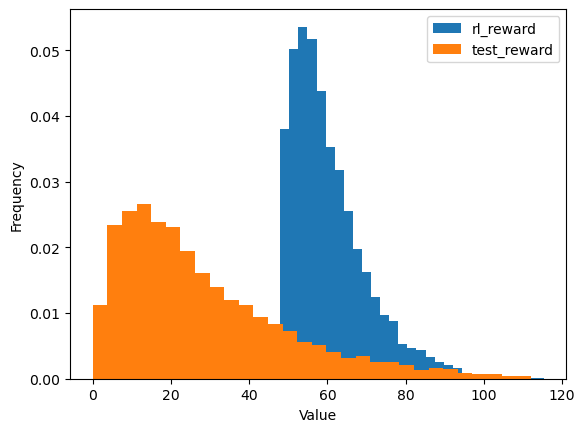

In [39]:
plt.hist(rew,bins=30,density=True,label='rl_reward')
plt.hist(y_test,bins=30,density=True,label='test_reward')
# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()
